# Climate-Friendly Food Systems (CFFS) Labelling Project

### The University of British Columbia

***

## Part V: Labelling Recipes

## Set up and Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from configparser import ConfigParser

In [2]:
# RUN ONLY ONCE
# os.chdir is used to change the current directory to the specified path
os.chdir("../") # Sets path to the repo folder as it is one level above where this file exists!
path = os.getcwd()
print(path)

/Users/vivaanwadhwa/Documents/GitHub/CFFS_sharon_2024


## Set Baselines

Make sure to run ```Label_Baseline_Calculation/baseline_OK.ipynb``` if there is a change in the baseline calculation or if a new parameter is added, update accordingly.

In [3]:
config = ConfigParser()
"""
This script reads baseline environmental impact values from a configuration file and calculates a cutoff value for greenhouse gas (GHG) emissions.

The configuration file is expected to be located at "data/Misc/data_for_calculating_baseline/baseline.ini" and should contain the following sections and keys:
- [baseline]
    - GHG_baseline: The baseline value for greenhouse gas emissions.
    - nitrogen_baseline: The baseline value for nitrogen usage.
    - water_baseline: The baseline value for water usage.
    - land_baseline: The baseline value for land usage.

The script performs the following steps:
1. Reads the configuration file using ConfigParser.
2. Extracts the baseline values for GHG, nitrogen, water, and land from the configuration file.
3. Calculates a cutoff value for GHG emissions, which is half of the overall GHG baseline.
4. Prints the baseline values for GHG, nitrogen, water, and land.

Variables:
- overall_baseline (float): The overall baseline value for GHG emissions.
- fifty_cutoff (float): The cutoff value for GHG emissions, calculated as half of the overall baseline.
- GHG_baseline (float): The baseline value for GHG emissions.
- nitrogen_baseline (float): The baseline value for nitrogen usage.
- water_baseline (float): The baseline value for water usage.
- land_baseline (float): The baseline value for land usage.

Usage:
This script is intended to be used as part of a larger project for calculating and analyzing environmental impacts. Ensure that the configuration file is correctly formatted and located at the specified path before running the script.
"""
config.read("data/Misc/data_for_calculating_baseline/baseline.ini")

overall_baseline = float(config["baseline"]["GHG_baseline"])
fifty_cutoff = overall_baseline/2

GHG_baseline = float(config["baseline"]["GHG_baseline"])
nitrogen_baseline = float(config["baseline"]["nitrogen_baseline"])
water_baseline = float(config["baseline"]["water_baseline"])
land_baseline = float(config["baseline"]["land_baseline"])
print(GHG_baseline,nitrogen_baseline,water_baseline,land_baseline)

364.61114734025256 4.428944853430558 1320.569404551064 0.8534548672606304


In [4]:
# CHANGE THIS AS NEEDED:
# restaurant_name = "OK24-25"
# restaurant_name = "Gather24-25"
# restaurant_name = "Totem24-25"
# restaurant_name = "HARVEST_FESTIVAL"
# restaurant_name = "SAGE_CATERING"
restaurant_name = "PERUGIA_CAFE"

In [5]:
def create_ghg_label(label):
    # determine the GHG label based on the given label value and predefined cutoffs
    if label > overall_baseline:
        # if the label value is > than overall baseline, assign "Red" label
        return "Red"
    elif (label <= overall_baseline) & (label > fifty_cutoff):
        # if the label value is between overall baseline and fifty_cutoff, assign "Yellow" label
        return "Yellow"
    elif label <= fifty_cutoff:
        # if the label value is less than or equal to the fifty_cutoff, assign "Green" label
        return "Green"


In [6]:
def create_results_all_factors(df):
    # create a Combined Label based on different factors for each row in the DataFrame
    df["Combined Label"] = ""

    # add another parameter: n so that change the number of factors instead of multiplying by 3

    def calculate_all_factors(ghg, nitrogen, water, land):
        # calculate the combined label value based on the given factors
        weighted_ghg = ghg / (4 * GHG_baseline)
        weighted_nitrogen = nitrogen / (4 * nitrogen_baseline)
        weighted_water = water / (4 * water_baseline)

        # most recently added
        weighted_land = land / (4 * land_baseline)

        return weighted_ghg + weighted_nitrogen + weighted_water + weighted_land


    for ind, row in df.iterrows():
        # iterate over each row in the DataFrame and calculate the combined label
        label = calculate_all_factors(row["GHG Emission (g) / 100g"], row["N lost (g) / 100g"],
                                      row["Stress-Weighted Water Use (L) / 100g"],
                                      row['Land Use (m^2) / 100g'])

        if label <= 0.5:
            # if the label value is less than or equal to 0.5, assign "Green" label
            df.loc[ind, "Combined Label"] = "Green"
        elif label >= 1:
            # if the label value is greater than or equal to 1, assign "Red" label
            df.loc[ind, "Combined Label"] = "Red"
        elif (label > 0.5) or (label < 1):
            # if the label value is between 0.5 and 1, assign "Yellow" label
            df.loc[ind, "Combined Label"] = "Yellow"
    return df


In [7]:
def add_menu_names(df, dict):
    # add menu names to the DataFrame based on a dictionary
    df["Displayed Name"] = ""
    menu_name = list(dict.keys())
    menu_ID = list(dict.values())
    for ind, row in df.iterrows():
        searchID = row["ProdId"]
        if searchID in menu_ID:
            # if the product ID is found in the menu_ID list, retrieve the corresponding name
            position = menu_ID.index(searchID)
            name = menu_name[position]
            df.loc[ind, "Displayed Name"] = name
        else:
            continue
    name_col = df.pop("Displayed Name")
    df.insert(0, "Displayed Name", name_col)
    df = df.dropna(subset=["Displayed Name"])

    df_temp = df["Displayed Name"].str.split("|", expand=True)
    df["Category"] = df_temp[0]
    df["Displayed Name"] = df_temp[1]
    name_col2 = df.pop("Category")
    df.insert(0, "Category", name_col2)
    # returns the modified DataFrame with the added "Category" and "Displayed Name" columns
    return df


In [8]:
def create_final_counts(df):
    # Define possible labels for both GHG Only and Combined labels
    labels = ["Red", "Yellow", "Green"]
    
    # Count the occurrences of GHG Only labels, defaulting to 0 if any label is missing
    ghg_counts = df["GHG Only Label"].value_counts()
    ghg_red = ghg_counts.get("Red", 0)
    ghg_yellow = ghg_counts.get("Yellow", 0)
    ghg_green = ghg_counts.get("Green", 0)
    
    # Count the occurrences of Combined labels, defaulting to 0 if any label is missing
    combined_counts = df["Combined Label"].value_counts()
    all_red = combined_counts.get("Red", 0)
    all_yellow = combined_counts.get("Yellow", 0)
    all_green = combined_counts.get("Green", 0)
    
    # Print counts for debugging purposes
    print(all_red, all_yellow, all_green)
    
    # Create a dictionary to store the label counts
    data = {
        "GHG Label Counts": [ghg_red, ghg_yellow, ghg_green],
        "Combined Label Counts": [all_red, all_yellow, all_green]
    }
    
    # Create a DataFrame from the label counts data and return it
    results = pd.DataFrame(data, index=labels)
    return results


In [9]:
def create_visualizations(df):
    df.reset_index(inplace=True)
    df = df.rename(columns={"index": "Color"})
    sns.set_theme(style="darkgrid")
    palette = {"Green": "tab:green", "Red": "tab:red", "Yellow": "tab:orange", "Sum": "tab:blue"}
    fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharex=False, sharey=True)
    fig.suptitle("Emission Label Counts")
    ax1 = sns.barplot(data=df, x=df["Color"], y=df["GHG Label Counts"], ax=axes[0], palette=palette)
    ax1.set_title("GHG Emission Label")
    ax1.set_ylabel("Counts")
    ax1.set_xlabel("")
    ax2 = sns.barplot(data=df, x=df["Color"], y=df["Combined Label Counts"], ax=axes[1], palette=palette)
    ax2.set_title("Combined Emissions Label")
    ax2.set_ylabel("")
    ax2.set_xlabel("")
    fig.title = "Color Comparison"
    ax1.set_title = "GHG Emission Label Counts"
    ax2.set_title = "Combined Emissions Label Counts"
    ax2.set_ylabel = ""
    for ax in [ax1, ax2]:
        for i in ax.containers:
            ax.bar_label(i, )
    plt.tight_layout()
    plt.savefig(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/" + restaurant_name + "Summary_fig.png")
    plt.show()

In [10]:
def create_category_true(df):
    # create category columns for True values in the DataFrame

    # create empty columns for each category
    df["RED"] = ""
    df["YELLOW"] = ""
    df["GREEN"] = ""
    # iterate over each row in the DataFrame
    for ind, row in df.iterrows():
        # Check the value of the Combined Label column and assign "TRUE" to the corresponding category column
        if row["Combined Label"] == "Red":
            df.loc[ind, "RED"] = "TRUE"
        if row["Combined Label"] == "Yellow":
            df.loc[ind, "YELLOW"] = "TRUE"
        if row["Combined Label"] == "Green":
            df.loc[ind, "GREEN"] = "TRUE"
    # adds category columns for True values based on the Combined Label column
    return df


In [11]:
products = pd.read_csv(os.path.join(os.getcwd(), "data", "final", "Recipes Footprints.csv"))

In [12]:
final = products.copy()
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,R-18166,CHICKEN|Quarter,ZDONT USE FOOD,425.277778,1868.364297,48.229192,4.972957,152.92,138.28,439.33,11.34,35.96,32.52,1.17
1,R-37980,ENTREE|Rst Chicken|Pasta,FOOD - HOT,725.277778,2572.062297,51.793192,2.776200,272.60,4679.23,354.63,7.14,37.59,645.16,0.38
2,R-72930,FLATBREAD|BBQ Chicken,FOOD - SANDWICH & WRAPS,223.319444,740.804874,15.034598,1.749719,91.41,2329.76,331.72,6.73,40.93,1043.24,0.78
3,R-74208,FLATBREAD|Caprese,FOOD - SANDWICH & WRAPS,200.000000,648.082500,4.140500,1.804350,87.48,4458.88,324.04,2.07,43.74,2229.44,0.90
4,R-74207,FLATBREAD|Chicken Parmesan,FOOD - SANDWICH & WRAPS,216.319444,826.409127,15.845772,1.839118,108.54,3182.37,382.03,7.33,50.18,1471.14,0.85
5,R-74115,FLATBREAD|Meat Lover,FOOD - SANDWICH & WRAPS,175.000000,1148.498000,14.676500,2.380000,215.89,7169.44,656.28,8.39,123.37,4096.82,1.36
6,R-74228,FLATBREAD|Spicy Veggie,FOOD - SANDWICH & WRAPS,187.000000,465.617237,4.685073,0.921719,79.38,3496.46,248.99,2.51,42.45,1869.76,0.49
7,R-74227,PASTA|Baked|Pesto Formaggi,PASTA,614.666836,2489.915253,22.308162,2.960633,278.48,18051.73,405.08,3.63,45.31,2936.83,0.48
8,R-74225,PASTA|Baked|Pomodoro Formaggi,PASTA,614.666836,2305.489758,21.495694,2.417864,264.90,17242.22,375.08,3.50,43.10,2805.13,0.39
9,R-54272,PASTA|Baked|Quattro Formaggi,PASTA,614.666836,2389.208508,22.230694,2.494739,272.30,17608.84,388.70,3.62,44.30,2864.78,0.41


In [13]:
final["GHG Only Label"] = final["GHG Emission (g) / 100g"].apply(lambda x: create_ghg_label(x))
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label
0,R-18166,CHICKEN|Quarter,ZDONT USE FOOD,425.277778,1868.364297,48.229192,4.972957,152.92,138.28,439.33,11.34,35.96,32.52,1.17,Red
1,R-37980,ENTREE|Rst Chicken|Pasta,FOOD - HOT,725.277778,2572.062297,51.793192,2.776200,272.60,4679.23,354.63,7.14,37.59,645.16,0.38,Yellow
2,R-72930,FLATBREAD|BBQ Chicken,FOOD - SANDWICH & WRAPS,223.319444,740.804874,15.034598,1.749719,91.41,2329.76,331.72,6.73,40.93,1043.24,0.78,Yellow
3,R-74208,FLATBREAD|Caprese,FOOD - SANDWICH & WRAPS,200.000000,648.082500,4.140500,1.804350,87.48,4458.88,324.04,2.07,43.74,2229.44,0.90,Yellow
4,R-74207,FLATBREAD|Chicken Parmesan,FOOD - SANDWICH & WRAPS,216.319444,826.409127,15.845772,1.839118,108.54,3182.37,382.03,7.33,50.18,1471.14,0.85,Red
5,R-74115,FLATBREAD|Meat Lover,FOOD - SANDWICH & WRAPS,175.000000,1148.498000,14.676500,2.380000,215.89,7169.44,656.28,8.39,123.37,4096.82,1.36,Red
6,R-74228,FLATBREAD|Spicy Veggie,FOOD - SANDWICH & WRAPS,187.000000,465.617237,4.685073,0.921719,79.38,3496.46,248.99,2.51,42.45,1869.76,0.49,Yellow
7,R-74227,PASTA|Baked|Pesto Formaggi,PASTA,614.666836,2489.915253,22.308162,2.960633,278.48,18051.73,405.08,3.63,45.31,2936.83,0.48,Red
8,R-74225,PASTA|Baked|Pomodoro Formaggi,PASTA,614.666836,2305.489758,21.495694,2.417864,264.90,17242.22,375.08,3.50,43.10,2805.13,0.39,Red
9,R-54272,PASTA|Baked|Quattro Formaggi,PASTA,614.666836,2389.208508,22.230694,2.494739,272.30,17608.84,388.70,3.62,44.30,2864.78,0.41,Red


In [14]:
final = create_results_all_factors(final)
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,R-18166,CHICKEN|Quarter,ZDONT USE FOOD,425.277778,1868.364297,48.229192,4.972957,152.92,138.28,439.33,11.34,35.96,32.52,1.17,Red,Red
1,R-37980,ENTREE|Rst Chicken|Pasta,FOOD - HOT,725.277778,2572.062297,51.793192,2.776200,272.60,4679.23,354.63,7.14,37.59,645.16,0.38,Yellow,Yellow
2,R-72930,FLATBREAD|BBQ Chicken,FOOD - SANDWICH & WRAPS,223.319444,740.804874,15.034598,1.749719,91.41,2329.76,331.72,6.73,40.93,1043.24,0.78,Yellow,Red
3,R-74208,FLATBREAD|Caprese,FOOD - SANDWICH & WRAPS,200.000000,648.082500,4.140500,1.804350,87.48,4458.88,324.04,2.07,43.74,2229.44,0.90,Yellow,Red
4,R-74207,FLATBREAD|Chicken Parmesan,FOOD - SANDWICH & WRAPS,216.319444,826.409127,15.845772,1.839118,108.54,3182.37,382.03,7.33,50.18,1471.14,0.85,Red,Red
5,R-74115,FLATBREAD|Meat Lover,FOOD - SANDWICH & WRAPS,175.000000,1148.498000,14.676500,2.380000,215.89,7169.44,656.28,8.39,123.37,4096.82,1.36,Red,Red
6,R-74228,FLATBREAD|Spicy Veggie,FOOD - SANDWICH & WRAPS,187.000000,465.617237,4.685073,0.921719,79.38,3496.46,248.99,2.51,42.45,1869.76,0.49,Yellow,Yellow
7,R-74227,PASTA|Baked|Pesto Formaggi,PASTA,614.666836,2489.915253,22.308162,2.960633,278.48,18051.73,405.08,3.63,45.31,2936.83,0.48,Red,Red
8,R-74225,PASTA|Baked|Pomodoro Formaggi,PASTA,614.666836,2305.489758,21.495694,2.417864,264.90,17242.22,375.08,3.50,43.10,2805.13,0.39,Red,Red
9,R-54272,PASTA|Baked|Quattro Formaggi,PASTA,614.666836,2389.208508,22.230694,2.494739,272.30,17608.84,388.70,3.62,44.30,2864.78,0.41,Red,Red


In [15]:
final.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".csv", 
             index=False)
final.to_excel(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".xlsx", 
               sheet_name="Labels", index=False)

In [16]:
# CHANGE THE NAME AS NEEDED AS PER THE RESTAURANT:

OK_list = final.set_index('Description')['ProdId'].to_dict()
OK_list

{'CHICKEN|Quarter': 'R-18166',
 'ENTREE|Rst Chicken|Pasta': 'R-37980',
 'FLATBREAD|BBQ Chicken ': 'R-72930',
 'FLATBREAD|Caprese': 'R-74208',
 'FLATBREAD|Chicken Parmesan': 'R-74207',
 'FLATBREAD|Meat Lover': 'R-74115',
 'FLATBREAD|Spicy Veggie': 'R-74228',
 'PASTA|Baked|Pesto Formaggi': 'R-74227',
 'PASTA|Baked|Pomodoro Formaggi': 'R-74225',
 'PASTA|Baked|Quattro Formaggi': 'R-54272',
 'PASTA|Tossed|Butternut Tortell': 'R-67749',
 'PASTA|Tossed|Meatball': 'R-43528',
 'PASTA|Tossed|Mushroom Gnocchi': 'R-74120',
 'SAND|Italian Sub ': 'R-73018',
 'SALAD|Caesar*': 'P-62546',
 'SALAD|Mediterranean|Chickpea*': 'P-35417',
 'SALAD|Pesto Pasta': 'P-74324'}

In [17]:
final2 = final.copy()
final2 = add_menu_names(final, OK_list)
final2.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.csv",
                  index=False)
final2.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.xlsx",
                  index=False)

In [18]:
# # # ADDED FOR GATHER:
# final2 = pd.read_csv("C:/Users/ENTER_HERE/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.csv")
# final2.head()

In [19]:
counts = create_final_counts(final2)
all_ghg_num = counts["GHG Label Counts"].sum()
all_num = counts["Combined Label Counts"].sum()
sum_row = pd.Series(data={"GHG Label Counts": all_ghg_num, "Combined Label Counts": all_num}, name="Sum")
sum_row

10 7 0


GHG Label Counts         17
Combined Label Counts    17
Name: Sum, dtype: int64

In [20]:
# counts = counts.append(sum_row, ignore_index=False)
counts.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/"+restaurant_name+"_Summary.csv", index=False)
counts_print = pd.concat([counts, sum_row], ignore_index=True)
counts

,GHG Label Counts,Combined Label Counts
Red,8,10
Yellow,8,7
Green,1,0


/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_70895/3450104400.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=df, x=df["Color"], y=df["GHG Label Counts"], ax=axes[0], palette=palette)
/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_70895/3450104400.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=df, x=df["Color"], y=df["Combined Label Counts"], ax=axes[1], palette=palette)


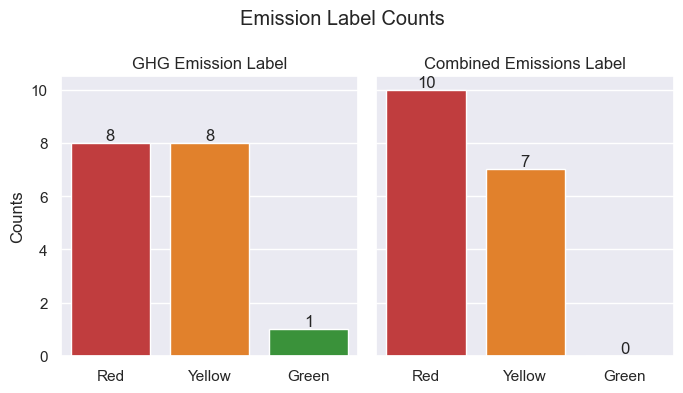

In [21]:
# THE BLUE BAR REPRESENTS THE SUM ROW WHICH IS THE TOTAL NUMBER OF RECIPES THAT HAVE BEEN ASSIGNED A LABEL
# EACH BAR REPRESENTS THE # OF RECIPES THAT WERE LABELLED WITH THAT SPECIFIC COLOUR

fig = create_visualizations(counts)
fig

In [22]:
final2.head()

,Category,Displayed Name,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,CHICKEN,Quarter,R-18166,CHICKEN|Quarter,ZDONT USE FOOD,425.277778,1868.364297,48.229192,4.972957,152.92,138.28,439.33,11.34,35.96,32.52,1.17,Red,Red
1,ENTREE,Rst Chicken,R-37980,ENTREE|Rst Chicken|Pasta,FOOD - HOT,725.277778,2572.062297,51.793192,2.776200,272.60,4679.23,354.63,7.14,37.59,645.16,0.38,Yellow,Yellow
2,FLATBREAD,BBQ Chicken,R-72930,FLATBREAD|BBQ Chicken,FOOD - SANDWICH & WRAPS,223.319444,740.804874,15.034598,1.749719,91.41,2329.76,331.72,6.73,40.93,1043.24,0.78,Yellow,Red
3,FLATBREAD,Caprese,R-74208,FLATBREAD|Caprese,FOOD - SANDWICH & WRAPS,200.000000,648.082500,4.140500,1.804350,87.48,4458.88,324.04,2.07,43.74,2229.44,0.90,Yellow,Red
4,FLATBREAD,Chicken Parmesan,R-74207,FLATBREAD|Chicken Parmesan,FOOD - SANDWICH & WRAPS,216.319444,826.409127,15.845772,1.839118,108.54,3182.37,382.03,7.33,50.18,1471.14,0.85,Red,Red


In [23]:
final3 = final2.drop(columns=['Category', 'Displayed Name', 'Weight (g)', 'GHG Only Label'])

In [24]:
final3.head()

,ProdId,Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,R-18166,CHICKEN|Quarter,ZDONT USE FOOD,1868.364297,48.229192,4.972957,152.92,138.28,439.33,11.34,35.96,32.52,1.17,Red
1,R-37980,ENTREE|Rst Chicken|Pasta,FOOD - HOT,2572.062297,51.793192,2.776200,272.60,4679.23,354.63,7.14,37.59,645.16,0.38,Yellow
2,R-72930,FLATBREAD|BBQ Chicken,FOOD - SANDWICH & WRAPS,740.804874,15.034598,1.749719,91.41,2329.76,331.72,6.73,40.93,1043.24,0.78,Red
3,R-74208,FLATBREAD|Caprese,FOOD - SANDWICH & WRAPS,648.082500,4.140500,1.804350,87.48,4458.88,324.04,2.07,43.74,2229.44,0.90,Red
4,R-74207,FLATBREAD|Chicken Parmesan,FOOD - SANDWICH & WRAPS,826.409127,15.845772,1.839118,108.54,3182.37,382.03,7.33,50.18,1471.14,0.85,Red


In [25]:
final3.rename(columns={'ProdId': 'Optimum Control ID', 'Description': 'OC Description'}, inplace=True)

In [26]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,R-18166,CHICKEN|Quarter,ZDONT USE FOOD,1868.364297,48.229192,4.972957,152.92,138.28,439.33,11.34,35.96,32.52,1.17,Red
1,R-37980,ENTREE|Rst Chicken|Pasta,FOOD - HOT,2572.062297,51.793192,2.776200,272.60,4679.23,354.63,7.14,37.59,645.16,0.38,Yellow
2,R-72930,FLATBREAD|BBQ Chicken,FOOD - SANDWICH & WRAPS,740.804874,15.034598,1.749719,91.41,2329.76,331.72,6.73,40.93,1043.24,0.78,Red
3,R-74208,FLATBREAD|Caprese,FOOD - SANDWICH & WRAPS,648.082500,4.140500,1.804350,87.48,4458.88,324.04,2.07,43.74,2229.44,0.90,Red
4,R-74207,FLATBREAD|Chicken Parmesan,FOOD - SANDWICH & WRAPS,826.409127,15.845772,1.839118,108.54,3182.37,382.03,7.33,50.18,1471.14,0.85,Red


In [27]:
final3['Red'] = final3['Combined Label'] == 'Red'
final3['Yellow'] = final3['Combined Label'] == 'Yellow'
final3['Green'] = final3['Combined Label'] == 'Green'

In [28]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label,Red,Yellow,Green
0,R-18166,CHICKEN|Quarter,ZDONT USE FOOD,1868.364297,48.229192,4.972957,152.92,138.28,439.33,11.34,35.96,32.52,1.17,Red,True,False,False
1,R-37980,ENTREE|Rst Chicken|Pasta,FOOD - HOT,2572.062297,51.793192,2.776200,272.60,4679.23,354.63,7.14,37.59,645.16,0.38,Yellow,False,True,False
2,R-72930,FLATBREAD|BBQ Chicken,FOOD - SANDWICH & WRAPS,740.804874,15.034598,1.749719,91.41,2329.76,331.72,6.73,40.93,1043.24,0.78,Red,True,False,False
3,R-74208,FLATBREAD|Caprese,FOOD - SANDWICH & WRAPS,648.082500,4.140500,1.804350,87.48,4458.88,324.04,2.07,43.74,2229.44,0.90,Red,True,False,False
4,R-74207,FLATBREAD|Chicken Parmesan,FOOD - SANDWICH & WRAPS,826.409127,15.845772,1.839118,108.54,3182.37,382.03,7.33,50.18,1471.14,0.85,Red,True,False,False


In [29]:
import pandas as pd


desired_column_order = [
    'Optimum Control ID', 'OC Description', 'SalesGroup', 'Combined Label', 'Red', 'Yellow', 'Green',
    'GHG Emission (g)', 'N lost (g)', 'Land Use (m^2)', 'Freshwater Withdrawals (L)', 
    'Stress-Weighted Water Use (L)', 'GHG Emission (g) / 100g', 'N lost (g) / 100g', 
    'Freshwater Withdrawals (L) / 100g', 'Stress-Weighted Water Use (L) / 100g', 
    'Land Use (m^2) / 100g'
]

# Create a new DataFrame with the desired column order
data_reordered = final3[desired_column_order]

# Print the reordered DataFrame
data_reordered.head()


,Optimum Control ID,OC Description,SalesGroup,Combined Label,Red,Yellow,Green,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,R-18166,CHICKEN|Quarter,ZDONT USE FOOD,Red,True,False,False,1868.364297,48.229192,4.972957,152.92,138.28,439.33,11.34,35.96,32.52,1.17
1,R-37980,ENTREE|Rst Chicken|Pasta,FOOD - HOT,Yellow,False,True,False,2572.062297,51.793192,2.776200,272.60,4679.23,354.63,7.14,37.59,645.16,0.38
2,R-72930,FLATBREAD|BBQ Chicken,FOOD - SANDWICH & WRAPS,Red,True,False,False,740.804874,15.034598,1.749719,91.41,2329.76,331.72,6.73,40.93,1043.24,0.78
3,R-74208,FLATBREAD|Caprese,FOOD - SANDWICH & WRAPS,Red,True,False,False,648.082500,4.140500,1.804350,87.48,4458.88,324.04,2.07,43.74,2229.44,0.90
4,R-74207,FLATBREAD|Chicken Parmesan,FOOD - SANDWICH & WRAPS,Red,True,False,False,826.409127,15.845772,1.839118,108.54,3182.37,382.03,7.33,50.18,1471.14,0.85


In [30]:
data_reordered.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Labelled_Data_"+restaurant_name+"_for_nutrislice.csv",
                  index=False)